# Example Notebook 2: Tension extraction

This notebook contains an exemplar tension extraction flow using the toolbox MusTen. 

In [93]:
%matplotlib inline
from __future__ import print_function

import librosa.display
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

from scipy.ndimage.filters import uniform_filter1d


import dissonant
import os
import scipy
import pandas as pd

import import_ipynb
from scipy import stats
import spleeter

from pydub import AudioSegment
import soundfile
from scipy.signal import savgol_filter
from scipy import signal
import scipy.signal

from scipy.stats import spearmanr

### Importing our custom functions

In [67]:
%run tension_functions.ipynb     #defining our custom functions


In [6]:
#For plotting
color_list = ["grey", "green", "red", "gold", "magenta", "midnightblue", "navy", "darkblue", "mediumblue", "blue", 
                 "blue", "blue"]

### 1. Importing and trimming the audio file


This function will load the audio as well as cut away silence in the beginning and in the end. This trimmed version will be saved as a new audio file in the music directory.

In [7]:
file_name = "Mendelssohn"
path = "./all_music/"
sr = 44100

y,sr,trimmed_audio_path = music_loading(file_name, path, sr)

./all_music/Mendelssohn.wav


### 2. Extracting the features

Here, we extract the features from our audio. For a more detailed view on the feature extraction, see example notebook 1.

The features include:
- Tempo
- Loudness
- Dissonance
- Pitch Height
- Onset frequency

Estimating tempo...
Estimating Onset frequency...
Estimating loudness...
Estimating Pitch...
Estimating polyphone pitch using Deep Salience
Computing HCQT...


2022-07-13 19:58:50.951709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Computing salience...
   > 1 / 9
1/1 [==============================] - 9s 9s/step
   > 2 / 9
1/1 [==============================] - 9s 9s/step
   > 3 / 9
1/1 [==============================] - 10s 10s/step
   > 4 / 9
1/1 [==============================] - 11s 11s/step
   > 5 / 9
1/1 [==============================] - 10s 10s/step
   > 6 / 9
1/1 [==============================] - 10s 10s/step
   > 7 / 9
1/1 [==============================] - 11s 11s/step
   > 8 / 9
1/1 [==============================] - 11s 11s/step
   > 9 / 9
1/1 [==============================] - 10s 10s/step
Saving output...
Estimating dissonance...


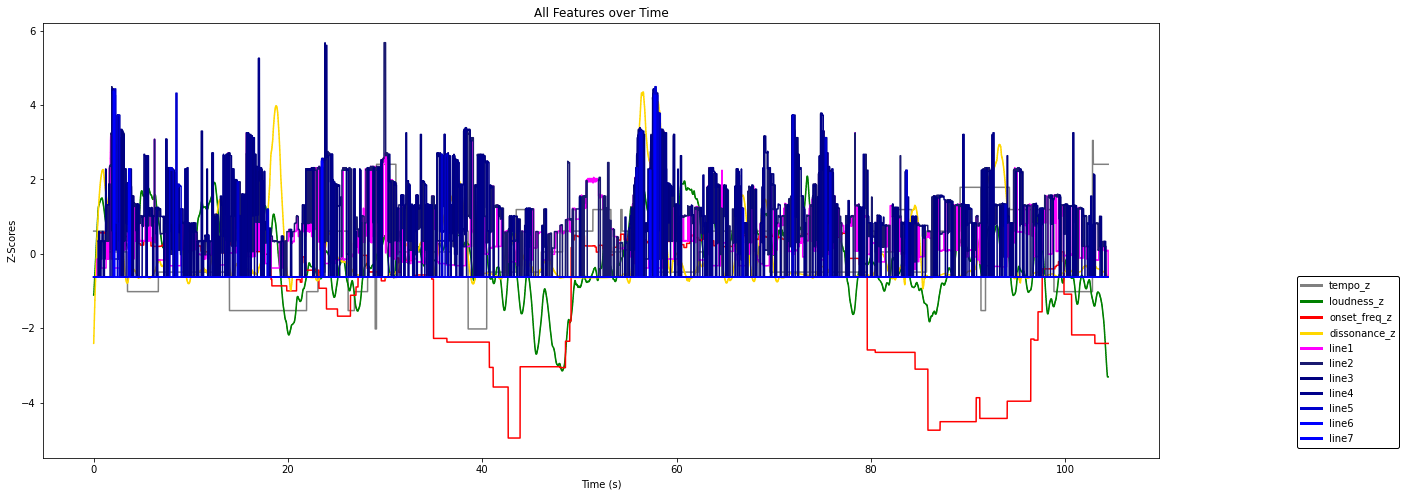

In [8]:
df_all_features, df_plot, pitch_df, onset_env = feature_extraction(y, sr, trimmed_audio_path)

plot_features(df_plot,color_list)

### 3. Tension extraction

Here, we will predict the tension from our features. Therefore, we will first smooth and resample the features and then submit them into the tension model.

In [43]:
features_smooth = feature_smoothing(df_plot)
all_features_10Hz, all_features_10Hz_unsmoothed = feature_resampling_10Hz(features_smooth, df_plot)
  

Extracting the tension prediction with the weighted tension prediction model.

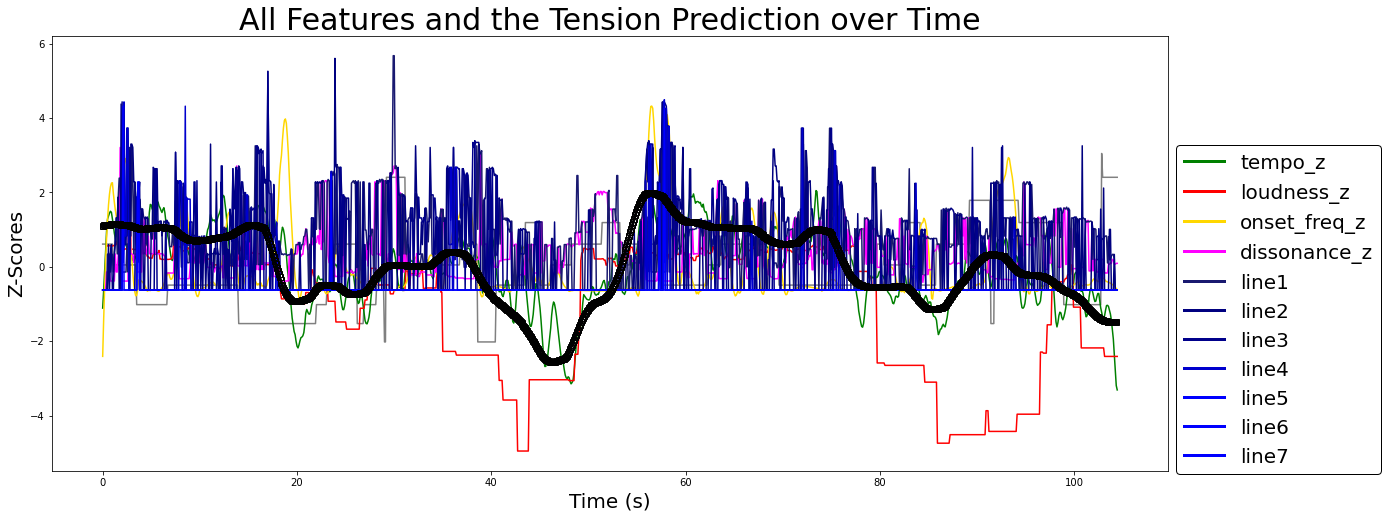

In [68]:
slopes_weights = tension_extraction_10Hz_weights(all_features_10Hz, model_configuration = "optimized")

plot_tension_and_features_10Hz(slopes_weights, all_features_10Hz_unsmoothed, color_list)

And extracting tension with the window model.

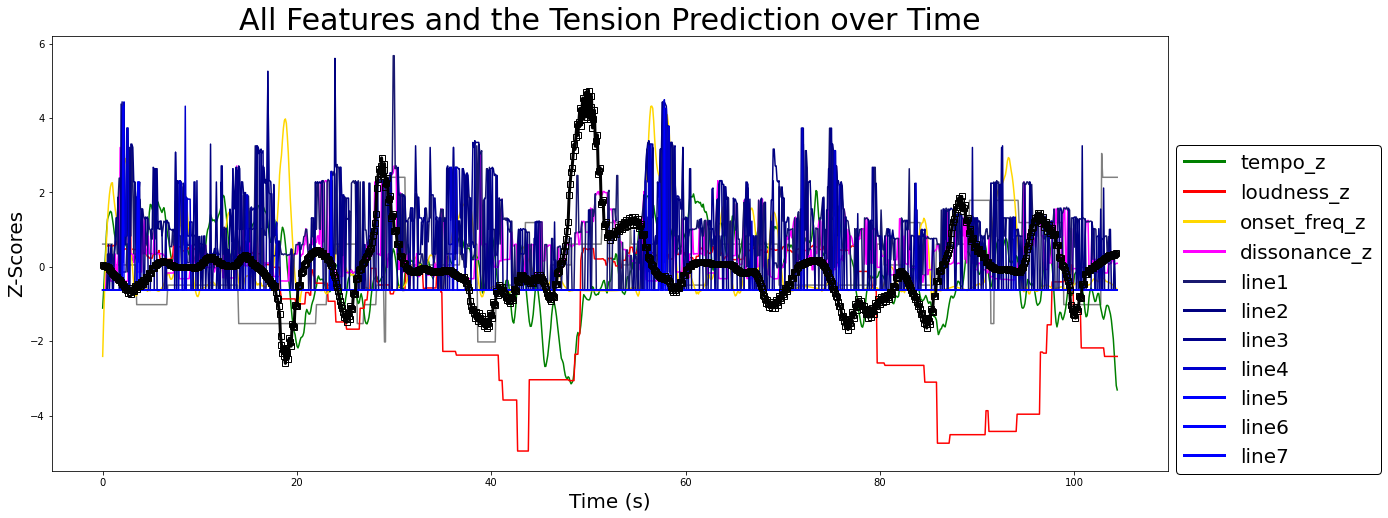

In [72]:
slopes_window = tension_extraction_10Hz_window(all_features_10Hz, model_configuration = "original")

plot_tension_and_features_10Hz(slopes_window, all_features_10Hz_unsmoothed, color_list)

### 4. Overlap with the Behavioral Tension Ratings

Finally, we will assess the overlap with our behavioral tension ratings. 

In [73]:
#Retrieving the behavioral data (standardized and sampled at 10 Hz)
%store -r piece_dfs

for df in piece_dfs:
    if df['piece'][0] == "music/Mendelssohn.wav":
        mendelssohn_ratings = df

Now we plot the mean tension ratings as well as our tension predictions from both model configurations. 

Text(0, 0.5, 'Z-Scores')

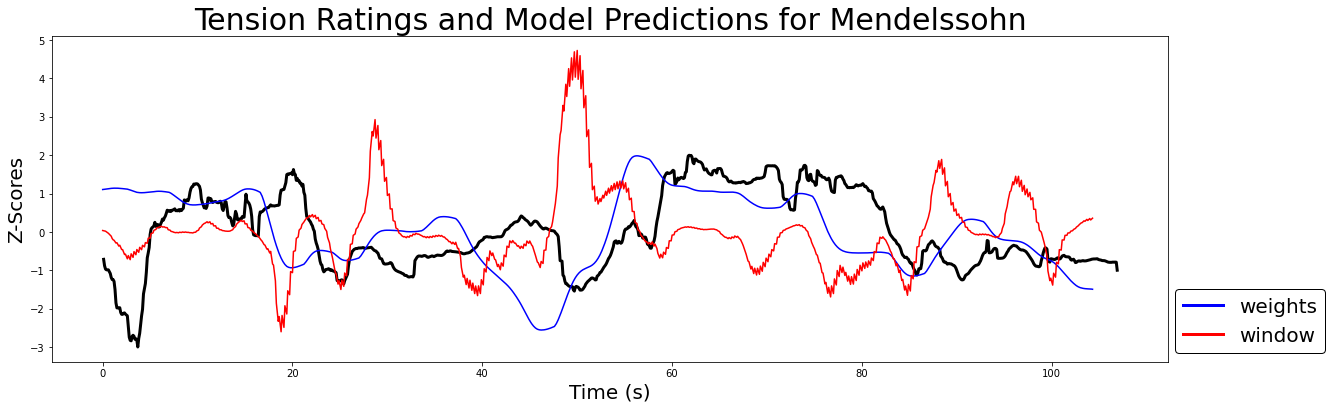

In [89]:
custom_lines = []
methods = ['weights', 'window']

plt.figure(figsize = [20,6])

piece = 'Mendelssohn'

plt.plot(mendelssohn_ratings['time'], mendelssohn_ratings['mean_tension'], color = "black", linewidth = 3)
plt.plot(slopes_weights['time'], slopes_weights['prediction'], color = "blue")
custom_lines.append(Line2D([0], [0], color = 'blue', lw = 3))
plt.plot(slopes_window['time'], slopes_window['prediction'], color = "red")
custom_lines.append(Line2D([0], [0], color = 'red', lw = 3))

plt.legend(custom_lines, methods , 
           loc='right', bbox_to_anchor=(1.15, 0.125), fancybox=True, facecolor='white', framealpha=1, 
          edgecolor = "black", fontsize = 20)

plt.title("Tension Ratings and Model Predictions for Mendelssohn", fontsize = 30)
plt.xlabel("Time (s)", fontsize = 20)
plt.ylabel("Z-Scores", fontsize = 20)

#### Correlations

Now, we will calculate time shifted spearman correlations between the tension ratings and the tension predictions. 

In [90]:
# Time lagged cross correlation
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    cor,pval = spearmanr(datax, datay.shift(lag), nan_policy = "omit")
    return cor

Calculating the correlations

In [122]:
##Weighted model
merged_weights = pd.merge(mendelssohn_ratings, slopes_weights, on = "time")

#Lags = -4 to -2 seconds
lags = np.arange(-40, -20, 1) 
rs_weights = np.nan_to_num([crosscorr(merged_weights['prediction'], merged_weights['mean_tension'], lag) for lag in lags])

#Getting the maximum correlations and the lags
max_cor_weights = max(rs_weights)
max_arg_weights = np.argmax(rs_weights)
lag_weights = 4-max_arg_weights/10


##Window model
merged_windows = pd.merge(mendelssohn_ratings, slopes_window, on = "time")

#Lags = -20 to 0 because we expect a relatively small negative shift of the tension ratings
lags = np.arange(-40, -20, 1)  # contrained

rs_windows = np.nan_to_num([crosscorr(merged_windows['prediction'], merged_windows['mean_tension'], lag) for lag in lags])

#Getting the maximum correlations and the lags
max_cor_windows = max(rs_windows)
arg_windows = np.argmax(rs_windows)
lag_windows = 4-arg/10


In [124]:
correlations = [max_cor_weights, max_cor_windows]
method = ['weights', 'windows']
lag = [lag_weights, lag_windows]

pd.DataFrame(zip(method, correlations, lag), columns = ["Method", "Correlation", "Lag"])


,Method,Correlation,Lag
0,weights,0.792922,3.0
1,windows,0.216092,4.0
